In [16]:
from tensorflow.keras.utils import plot_model

## Dense + FC

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(28*28, activation='tanh'))
    model.add(Reshape((28, 28, 1)))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Flatten(input_shape=(28, 28, 1)))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='sigmoid'))

    return model


(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)


def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Print the loss for every p_epoch epochs
        if epoch % p_epoch == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc

In [22]:
generator_dense = build_generator()
generator_dense.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_27 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_40 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_28 (Ba  (None, 512)               2048      
 tchNormalization)                                   

In [23]:
discriminator_dense = build_discriminator()
discriminator_dense.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_43 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)             

In [50]:
generator_fc, d_losses, g_losses, d_acc = train_gan(epochs=1000)

1/1 [==============================] - 0s 38ms/step
0 [D loss: 0.607909083366394, acc.: 45.3125%] [G loss: 0.43598178029060364]
1/1 [==============================] - 0s 9ms/step
100 [D loss: 0.011884910752996802, acc.: 100.0%] [G loss: 4.5522565841674805]
1/1 [==============================] - 0s 8ms/step
200 [D loss: 0.022855698131024837, acc.: 100.0%] [G loss: 4.694035530090332]
1/1 [==============================] - 0s 9ms/step
300 [D loss: 0.1436990313231945, acc.: 95.3125%] [G loss: 3.4131290912628174]
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step
400 [D loss: 0.5704258978366852, acc.: 64.0625%] [G loss: 1.5009515285491943]
1/1 [==============================] - 0s 8ms/step
500 [D loss: 0.7004620432853699, acc.: 48.4375%] [G loss: 0.6462541818618774]
1/1 [==============================] - 0s 7ms/step
600 [D loss: 0.6772487163543701, acc.: 48.4375%] [G loss: 0.6791254281997681]
1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step
700 [D loss: 0.6460273563861847, acc.: 54.6875%] [G loss: 0.6828010082244873]
1/1 [==============================] - 0s 9ms/step
800 [D loss: 0.6014712750911713, acc.: 71.875%] [G loss: 0.7834656238555908]
1/1 [==============================] - 0s 8ms/step
900 [D loss: 0.6758608818054199, acc.: 56.25%] [G loss: 0.7206992506980896]
1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step
Total training time: 45.56 seconds


1/1 [==============================] - 0s 43ms/step


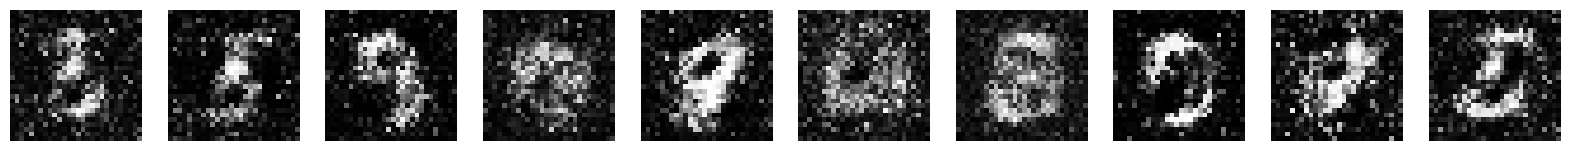

In [51]:
# Generate images after training
noise = np.random.normal(0, 1, (10, 100)) 
generated_images = generator_fc.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import sys
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the demension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)


def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    # using half batches for the discriminator ensures balanced and efficient training, 
    # better memory management, and more stable training dynamics in GANs.
    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Print the loss for every p_epoch epochs
        if epoch % p_epoch == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

    
    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc

In [25]:
generator_cnn = build_generator()
generator_cnn.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_10 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_30 (Ba  (None, 7, 7, 128)         512       
 tchNormalization)                                               
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 14, 14, 128)     

In [26]:
discriminator_cnn = build_discriminator()
discriminator_cnn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)            

In [46]:
generator_500, d_losses, g_losses, d_acc = train_gan(epochs=1000)

1/1 [==============================] - 0s 55ms/step
0 [D loss: 0.685494065284729, acc.: 31.25%] [G loss: 0.6789588332176208]
1/1 [==============================] - 0s 19ms/step
100 [D loss: 0.7628413736820221, acc.: 23.4375%] [G loss: 0.7174204587936401]
1/1 [==============================] - 0s 20ms/step
200 [D loss: 0.7080185413360596, acc.: 42.1875%] [G loss: 0.7140543460845947]
1/1 [==============================] - 0s 19ms/step
300 [D loss: 0.7183071672916412, acc.: 34.375%] [G loss: 0.7219854593276978]
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
400 [D loss: 0.6928502321243286, acc.: 51.5625%] [G loss: 0.6952056288719177]
1/1 [==============================] - 0s 19ms/step
500 [D loss: 0.704757958650589, acc.: 43.75%] [G loss: 0.7252351641654968]
1/1 [==============================] - 0s 21ms/step
600 [D loss: 0.706082671880722, acc.: 35.9375%] [G loss: 0.7239220142364502]
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
700 [D loss: 0.6997817754745483, acc.: 42.1875%] [G loss: 0.700847327709198]
1/1 [==============================] - 0s 20ms/step
800 [D loss: 0.686248779296875, acc.: 56.25%] [G loss: 0.7217938303947449]
1/1 [==============================] - 0s 18ms/step
900 [D loss: 0.7041721642017365, acc.: 40.625%] [G loss: 0.7050865888595581]
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
Total training time: 151.36 seconds


1/1 [==============================] - 0s 50ms/step


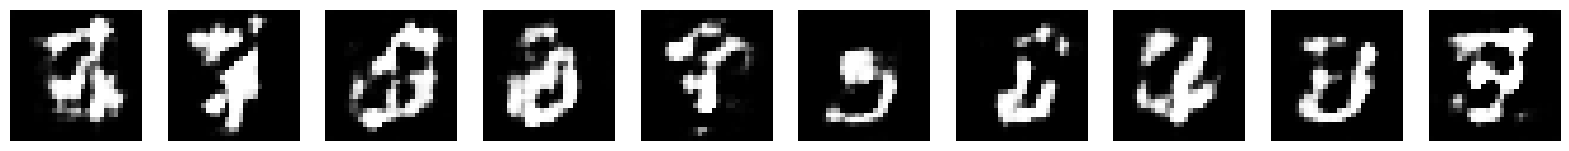

In [47]:
# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator_500.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + FID + 1000 epochs

In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores



In [48]:
# Training the GAN with FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 19ms/step
0 [D loss: 0.7108070850372314, acc.: 12.5%] [G loss: 0.6678398847579956] [FID: 698.7059663484483]
32/32 [==============================] - 0s 14ms/step
100 [D loss: 0.6363740563392639, acc.: 65.625%] [G loss: 0.8127986192703247] [FID: 165.66675111255307]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 16ms/step
200 [D loss: 0.7210093438625336, acc.: 37.5%] [G loss: 0.7195360660552979] [FID: 87.20359787017357]
32/32 [==============================] - 0s 15ms/step
300 [D loss: 0.70122891664505, acc.: 37.5%] [G loss: 0.7038894891738892] [FID: 85.88519360702023]
1/1 [==============================] - 0s 114ms/step


32/32 [==============================] - 1s 17ms/step
400 [D loss: 0.7123672366142273, acc.: 39.0625%] [G loss: 0.6993231773376465] [FID: 72.41516151441554]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 0s 15ms/step
500 [D loss: 0.7059338390827179, acc.: 40.625%] [G loss: 0.7067549824714661] [FID: 71.84218694265414]
32/32 [==============================] - 1s 17ms/step
600 [D loss: 0.7008708715438843, acc.: 46.875%] [G loss: 0.7188017964363098] [FID: 75.8081547818081]
1/1 [==============================] - 0s 25ms/step


32/32 [==============================] - 1s 16ms/step
700 [D loss: 0.7017464339733124, acc.: 45.3125%] [G loss: 0.7310952544212341] [FID: 68.91439301046437]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 16ms/step
800 [D loss: 0.6915153563022614, acc.: 50.0%] [G loss: 0.7165201306343079] [FID: 66.05138674417567]
32/32 [==============================] - 0s 15ms/step
900 [D loss: 0.6820398569107056, acc.: 54.6875%] [G loss: 0.7480006217956543] [FID: 142.43356258687126]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
Total training time: 190.75 seconds


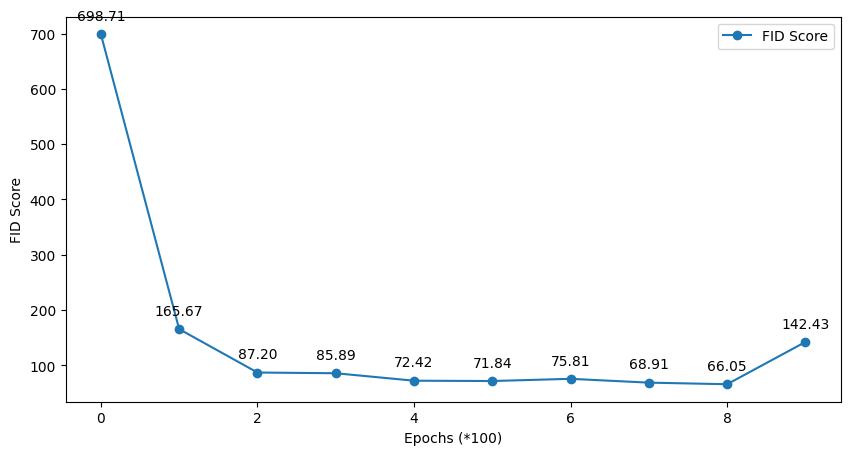

1/1 [==============================] - 0s 17ms/step


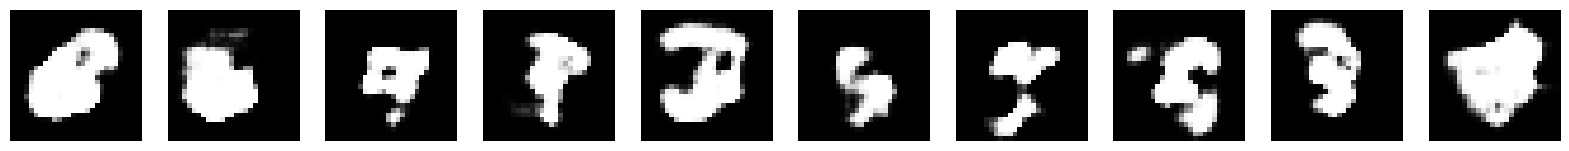

In [49]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

# 标注每个数据点
for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [51]:
# Training the GAN with FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 17ms/step
0 [D loss: 0.651642769575119, acc.: 46.875%] [G loss: 0.6357065439224243] [FID: 783.3447426356856]
32/32 [==============================] - 1s 16ms/step
100 [D loss: 0.7639965415000916, acc.: 20.3125%] [G loss: 0.7167040109634399] [FID: 108.09040447009798]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 0s 15ms/step
200 [D loss: 0.7137995362281799, acc.: 31.25%] [G loss: 0.7390925288200378] [FID: 88.10082130499018]
32/32 [==============================] - 0s 15ms/step
300 [D loss: 0.7033654749393463, acc.: 43.75%] [G loss: 0.7096824645996094] [FID: 70.40110535112252]
1/1 [==============================] - 0s 67ms/step


32/32 [==============================] - 0s 15ms/step
400 [D loss: 0.7163931131362915, acc.: 42.1875%] [G loss: 0.7107174396514893] [FID: 69.49373766202878]
1/1 [==============================] - 0s 24ms/step


32/32 [==============================] - 0s 14ms/step
500 [D loss: 0.7022398114204407, acc.: 51.5625%] [G loss: 0.7042266130447388] [FID: 69.7960112232569]
32/32 [==============================] - 0s 14ms/step
600 [D loss: 0.7078427374362946, acc.: 40.625%] [G loss: 0.7131937146186829] [FID: 86.85671295201472]
1/1 [==============================] - 0s 20ms/step


32/32 [==============================] - 0s 14ms/step
700 [D loss: 0.7013041079044342, acc.: 37.5%] [G loss: 0.712319552898407] [FID: 83.7726491793058]
1/1 [==============================] - 0s 21ms/step


32/32 [==============================] - 0s 14ms/step
800 [D loss: 0.7068849205970764, acc.: 37.5%] [G loss: 0.7065004706382751] [FID: 71.95999359681804]
32/32 [==============================] - 0s 15ms/step
900 [D loss: 0.6976528763771057, acc.: 50.0%] [G loss: 0.7213351726531982] [FID: 69.59672342078112]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step
Total training time: 183.75 seconds


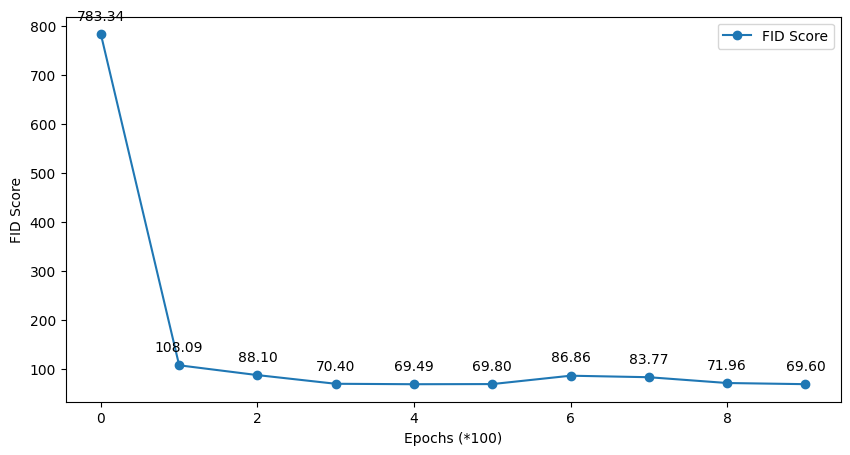

1/1 [==============================] - 0s 15ms/step


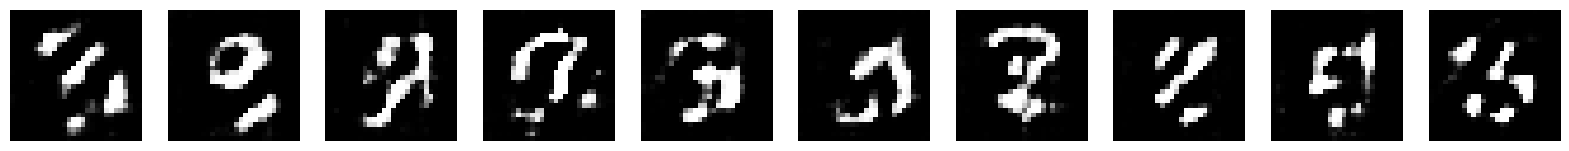

In [52]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

# 标注每个数据点
for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [53]:
# Training the GAN with FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 15ms/step
0 [D loss: 0.679859846830368, acc.: 51.5625%] [G loss: 0.671293318271637] [FID: 647.4007539589205]
32/32 [==============================] - 0s 14ms/step
100 [D loss: 0.608392059803009, acc.: 65.625%] [G loss: 1.0338503122329712] [FID: 203.48273193191676]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 1s 16ms/step
200 [D loss: 0.6513369977474213, acc.: 67.1875%] [G loss: 0.7406504154205322] [FID: 118.62812536374399]
32/32 [==============================] - 0s 14ms/step
300 [D loss: 0.706777036190033, acc.: 50.0%] [G loss: 0.7017875909805298] [FID: 87.97252933938442]
1/1 [==============================] - 0s 87ms/step


32/32 [==============================] - 0s 14ms/step
400 [D loss: 0.6934390366077423, acc.: 50.0%] [G loss: 0.7233855128288269] [FID: 89.51842168914916]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 0s 14ms/step
500 [D loss: 0.7057810723781586, acc.: 46.875%] [G loss: 0.7043863534927368] [FID: 75.20828773467365]
32/32 [==============================] - 0s 15ms/step
600 [D loss: 0.7014626860618591, acc.: 39.0625%] [G loss: 0.7098401188850403] [FID: 107.46871859813504]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 0s 14ms/step
700 [D loss: 0.6966422200202942, acc.: 42.1875%] [G loss: 0.7262232303619385] [FID: 83.44231546152558]
1/1 [==============================] - 0s 19ms/step


32/32 [==============================] - 0s 14ms/step
800 [D loss: 0.6860724985599518, acc.: 54.6875%] [G loss: 0.7186712026596069] [FID: 64.46511340579977]
32/32 [==============================] - 0s 14ms/step
900 [D loss: 0.6965168714523315, acc.: 48.4375%] [G loss: 0.7142263054847717] [FID: 60.25948417407973]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Total training time: 179.84 seconds


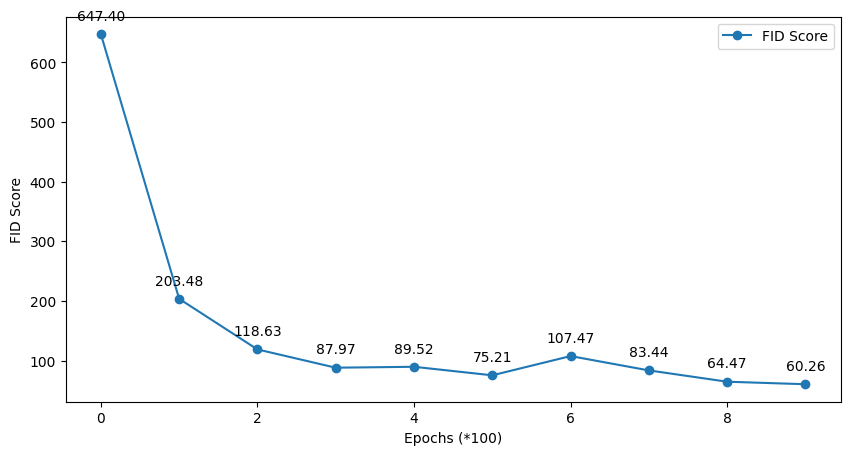

1/1 [==============================] - 0s 17ms/step


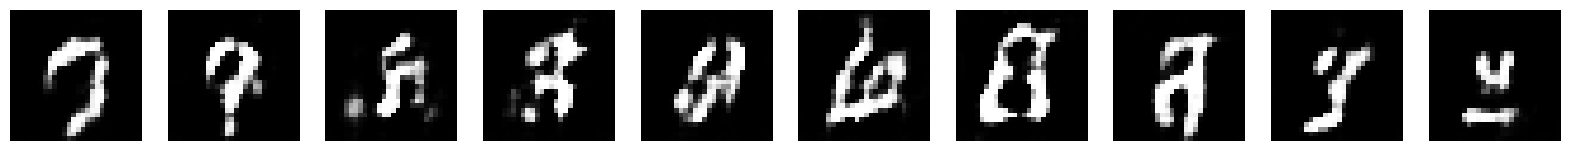

In [54]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

# 标注每个数据点
for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + FID + Data augmentation + 1000 epochs

In [64]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # increase the dimension
    model.add(Dense(7*7*128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 定义数据增强
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # 应用数据增强
        real_images_augmented = next(datagen.flow(real_images, batch_size=half_batch))

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images_augmented, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

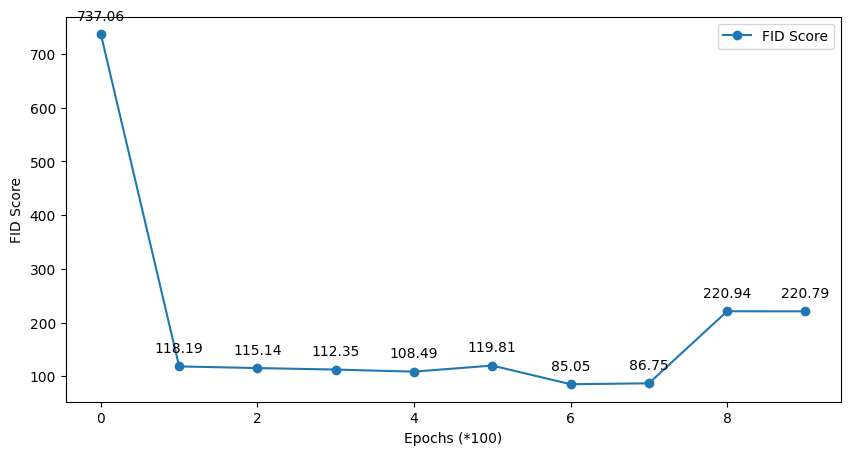

1/1 [==============================] - 0s 18ms/step


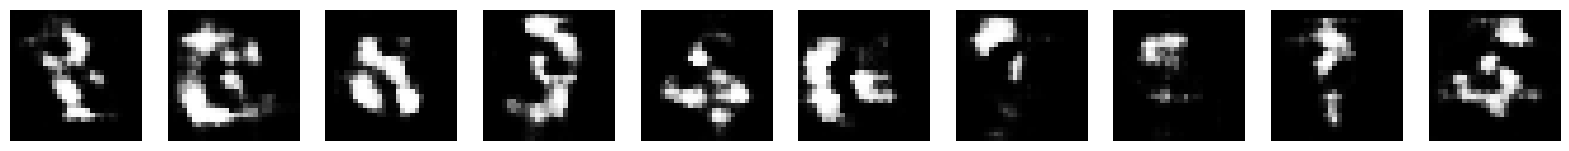

In [46]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [55]:
# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 15ms/step
0 [D loss: 0.7124409675598145, acc.: 12.5%] [G loss: 0.6784403920173645] [FID: 670.3244982267839]
32/32 [==============================] - 1s 16ms/step
100 [D loss: 0.6239662766456604, acc.: 68.75%] [G loss: 0.9494784474372864] [FID: 190.32971659968914]
1/1 [==============================] - 0s 21ms/step


32/32 [==============================] - 0s 15ms/step
200 [D loss: 0.7206841111183167, acc.: 35.9375%] [G loss: 0.7264549732208252] [FID: 99.2870003071689]
32/32 [==============================] - 0s 14ms/step
300 [D loss: 0.6978961527347565, acc.: 54.6875%] [G loss: 0.6971566677093506] [FID: 85.73610638825792]
1/1 [==============================] - 0s 51ms/step


32/32 [==============================] - 0s 15ms/step
400 [D loss: 0.705868661403656, acc.: 45.3125%] [G loss: 0.6985557079315186] [FID: 80.92510984821331]
1/1 [==============================] - 0s 23ms/step


32/32 [==============================] - 0s 14ms/step
500 [D loss: 0.699536919593811, acc.: 48.4375%] [G loss: 0.7100173830986023] [FID: 75.07406255191837]
32/32 [==============================] - 0s 14ms/step
600 [D loss: 0.6969319581985474, acc.: 50.0%] [G loss: 0.7230134606361389] [FID: 70.04348479384787]
1/1 [==============================] - 0s 20ms/step


32/32 [==============================] - 0s 14ms/step
700 [D loss: 0.6884692907333374, acc.: 56.25%] [G loss: 0.7186742424964905] [FID: 68.01442080531109]
1/1 [==============================] - 0s 21ms/step


32/32 [==============================] - 0s 15ms/step
800 [D loss: 0.6895850002765656, acc.: 51.5625%] [G loss: 0.7185992002487183] [FID: 66.53127234403428]
32/32 [==============================] - 0s 15ms/step
900 [D loss: 0.6977779865264893, acc.: 51.5625%] [G loss: 0.7144163250923157] [FID: 76.3348877412821]
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
Total training time: 181.34 seconds


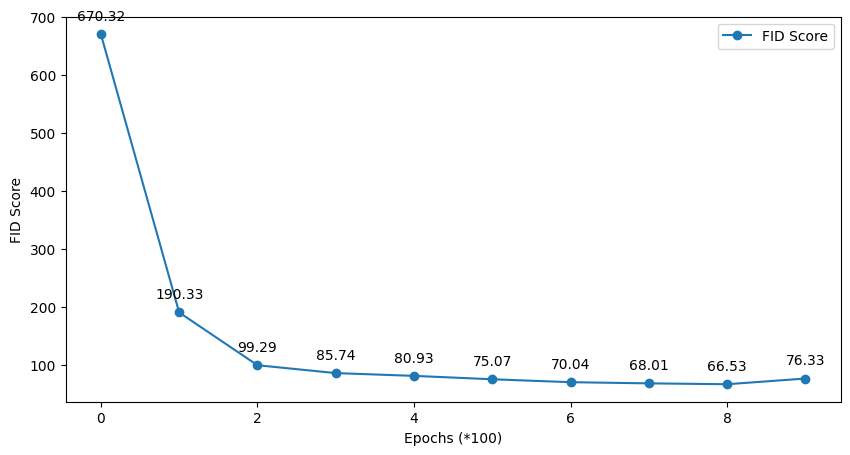

1/1 [==============================] - 0s 20ms/step


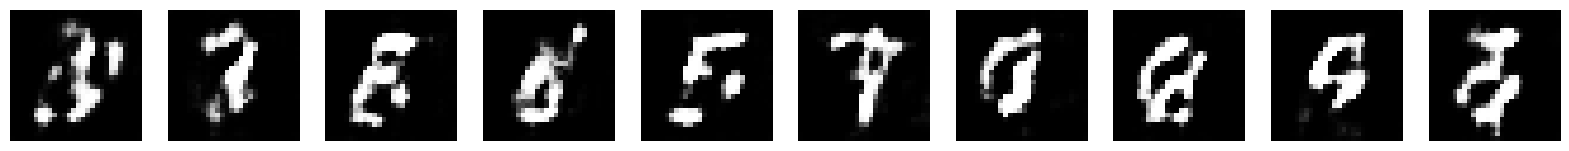

In [56]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [57]:
# Training the GAN with data augmentation and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 16ms/step
0 [D loss: 0.6891357004642487, acc.: 34.375%] [G loss: 0.6431775093078613] [FID: 681.7269893832463]
32/32 [==============================] - 1s 18ms/step
100 [D loss: 0.5883301794528961, acc.: 76.5625%] [G loss: 0.9183851480484009] [FID: 200.8622322347569]
1/1 [==============================] - 0s 28ms/step


32/32 [==============================] - 1s 16ms/step
200 [D loss: 0.7126651406288147, acc.: 45.3125%] [G loss: 0.7186173796653748] [FID: 99.00246254599497]
32/32 [==============================] - 0s 14ms/step
300 [D loss: 0.6966190338134766, acc.: 53.125%] [G loss: 0.7173454165458679] [FID: 85.1942696754533]
1/1 [==============================] - 0s 76ms/step


32/32 [==============================] - 0s 15ms/step
400 [D loss: 0.6950945854187012, acc.: 54.6875%] [G loss: 0.71588534116745] [FID: 81.57830927642104]
1/1 [==============================] - 0s 21ms/step


32/32 [==============================] - 1s 17ms/step
500 [D loss: 0.7046069204807281, acc.: 45.3125%] [G loss: 0.719692587852478] [FID: 75.17863346477749]
32/32 [==============================] - 1s 16ms/step
600 [D loss: 0.6876976788043976, acc.: 59.375%] [G loss: 0.715530514717102] [FID: 66.87377033027613]
1/1 [==============================] - 0s 24ms/step


32/32 [==============================] - 1s 16ms/step
700 [D loss: 0.6959008574485779, acc.: 53.125%] [G loss: 0.7337952852249146] [FID: 65.00692539066777]
1/1 [==============================] - 0s 28ms/step


32/32 [==============================] - 0s 15ms/step
800 [D loss: 0.6885123550891876, acc.: 51.5625%] [G loss: 0.7259398102760315] [FID: 60.931365779506166]
32/32 [==============================] - 1s 16ms/step
900 [D loss: 0.6887741684913635, acc.: 54.6875%] [G loss: 0.7197819948196411] [FID: 59.49150459175341]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
Total training time: 187.09 seconds


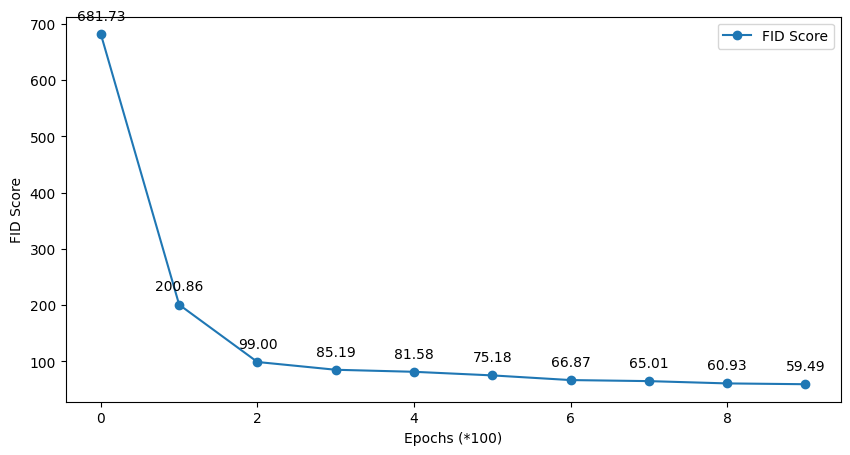

1/1 [==============================] - 0s 19ms/step


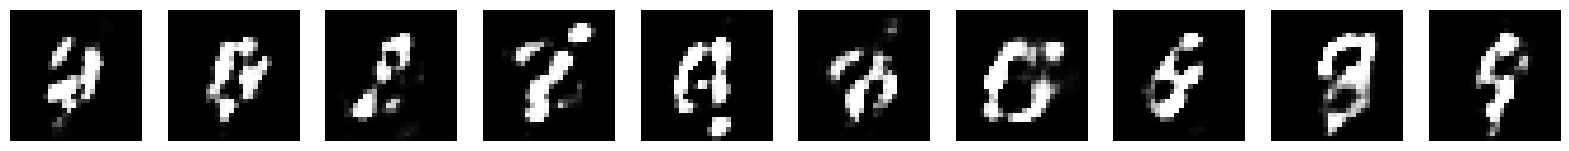

In [58]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## CNN + Add 1 Converlution Layer For Generator +  FID

In [67]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import numpy as np
import time
import matplotlib.pyplot as plt

np.random.seed(1000)
tf.random.set_seed(1000)

# input 100
# output 28*28*1

def build_generator():
    model = Sequential()
    
    # Adjust the first Dense layer to match the new expected shape after additional Conv2DTranspose
    model.add(Dense(7*7*256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))  # 14x14x128
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))  # 28x28x64
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # Output layer
    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))  # 28x28x1

    return model

# input 28*28*1
# output 1

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

# 计算FID函数
def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()  # Record the start time

    for epoch in range(epochs):
        # Select a random half batch of real images
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Generate a half batch of new fake images
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        # Record the losses
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        # Calculate FID every p_epoch epochs
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

In [68]:
# Training the GAN with an additional convolution layer in the generator and FID calculation
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000, batch_size=64, p_epoch=100)

32/32 [==============================] - 1s 19ms/step
0 [D loss: 0.680278480052948, acc.: 34.375%] [G loss: 0.6692808866500854] [FID: 791.2509541186503]
32/32 [==============================] - 1s 19ms/step
100 [D loss: 0.7613877058029175, acc.: 39.0625%] [G loss: 0.6332608461380005] [FID: 151.05466668935478]
1/1 [==============================] - 0s 27ms/step


32/32 [==============================] - 1s 19ms/step
200 [D loss: 0.7269706726074219, acc.: 35.9375%] [G loss: 0.7067985534667969] [FID: 88.1492798005171]
32/32 [==============================] - 1s 18ms/step
300 [D loss: 0.7153627872467041, acc.: 48.4375%] [G loss: 0.7171061038970947] [FID: 88.03778647281126]
1/1 [==============================] - 0s 75ms/step


32/32 [==============================] - 1s 21ms/step
400 [D loss: 0.7146957814693451, acc.: 34.375%] [G loss: 0.7151191234588623] [FID: 80.70087434026911]
1/1 [==============================] - 0s 28ms/step


32/32 [==============================] - 1s 21ms/step
500 [D loss: 0.7196377515792847, acc.: 28.125%] [G loss: 0.7073615193367004] [FID: 80.47580943019854]
32/32 [==============================] - 1s 21ms/step
600 [D loss: 0.7020527124404907, acc.: 45.3125%] [G loss: 0.7140301465988159] [FID: 83.29347547663329]
1/1 [==============================] - 0s 29ms/step


32/32 [==============================] - 1s 24ms/step
700 [D loss: 0.7021406888961792, acc.: 50.0%] [G loss: 0.7015273571014404] [FID: 76.93008611980017]
1/1 [==============================] - 0s 29ms/step


32/32 [==============================] - 1s 22ms/step
800 [D loss: 0.6873357594013214, acc.: 53.125%] [G loss: 0.7239410877227783] [FID: 92.31897767723356]
32/32 [==============================] - 1s 22ms/step
900 [D loss: 0.6952148377895355, acc.: 53.125%] [G loss: 0.7271908521652222] [FID: 81.26540805110268]
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 36ms/step
Total training time: 221.54 seconds


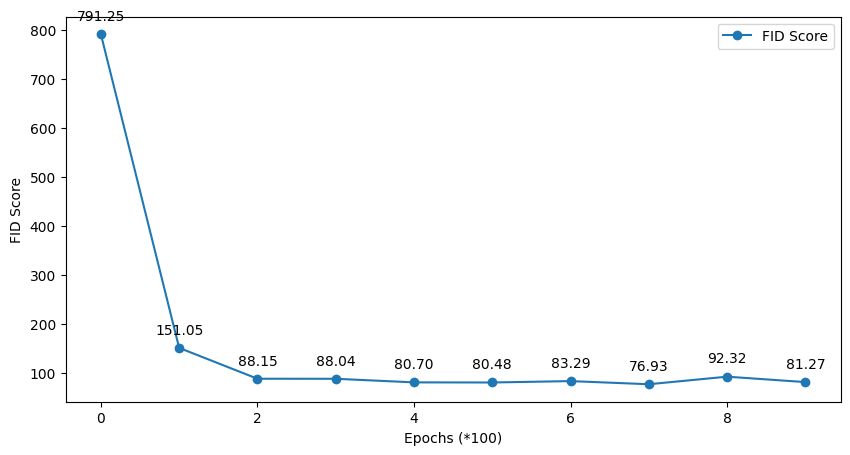

1/1 [==============================] - 0s 25ms/step


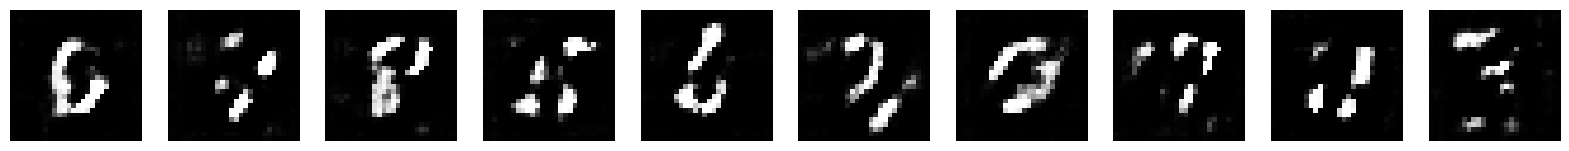

In [69]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score", marker='o')

for i, fid in enumerate(fid_scores):
    plt.annotate(f"{fid:.2f}", (i, fid), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Epochs (*100)")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# 10 100 dimension noise vector z
noise = np.random.normal(0, 1, (10, 100)) 

generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## Add more layer and data augmentation

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

np.random.seed(1000)
tf.random.set_seed(1000)

def build_generator():
    model = Sequential()
    
    model.add(Dense(7*7*256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    return model

def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        # Use data augmentation for real images
        augmented_real_images = next(datagen.flow(real_images, batch_size=half_batch, shuffle=False))

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores



In [3]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)

32/32 [==============================] - 1s 16ms/step
0 [D loss: 0.7010813355445862, acc.: 14.0625%] [G loss: 0.6619638204574585] [FID: 674.2963315211018]
32/32 [==============================] - 1s 19ms/step
100 [D loss: 0.6939715445041656, acc.: 46.875%] [G loss: 0.7485687732696533] [FID: 140.87590364181114]
32/32 [==============================] - 1s 19ms/step
200 [D loss: 0.7130197584629059, acc.: 35.9375%] [G loss: 0.715855062007904] [FID: 95.38527432854147]
32/32 [==============================] - 1s 19ms/step
300 [D loss: 0.6990796327590942, acc.: 43.75%] [G loss: 0.700308084487915] [FID: 94.71477612753728]
1/1 [==============================] - 0s 93ms/step


32/32 [==============================] - 1s 20ms/step
400 [D loss: 0.6917788982391357, acc.: 48.4375%] [G loss: 0.7076176404953003] [FID: 73.66920698562714]
32/32 [==============================] - 1s 19ms/step
500 [D loss: 0.6889185309410095, acc.: 59.375%] [G loss: 0.6986671686172485] [FID: 83.03642061034849]
32/32 [==============================] - 1s 21ms/step
600 [D loss: 0.6814075112342834, acc.: 56.25%] [G loss: 0.7113895416259766] [FID: 89.49510290309215]
1/1 [==============================] - 0s 24ms/step


32/32 [==============================] - 1s 19ms/step
700 [D loss: 0.6851991415023804, acc.: 59.375%] [G loss: 0.7463606595993042] [FID: 107.43593915914283]
32/32 [==============================] - 1s 21ms/step
800 [D loss: 0.6469468176364899, acc.: 76.5625%] [G loss: 0.8406908512115479] [FID: 102.51149710653016]
32/32 [==============================] - 1s 19ms/step
900 [D loss: 0.6521196067333221, acc.: 78.125%] [G loss: 0.7855138778686523] [FID: 68.20343103797539]
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step
Total training time: 224.30 seconds


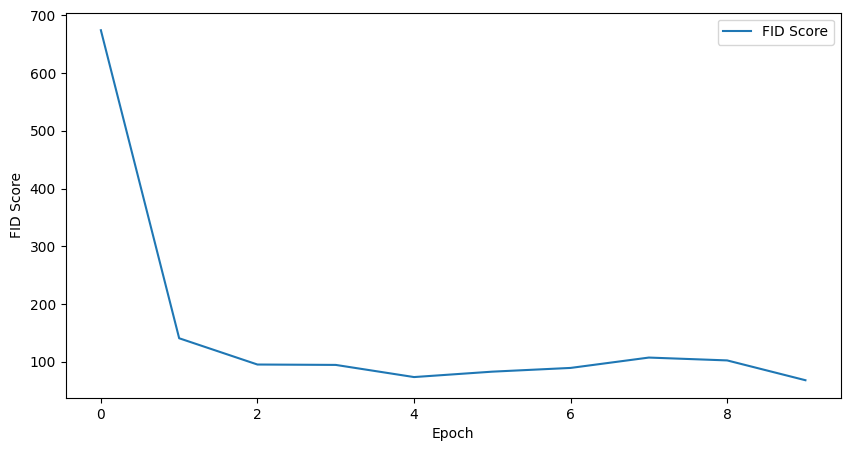

In [4]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

1/1 [==============================] - 0s 26ms/step


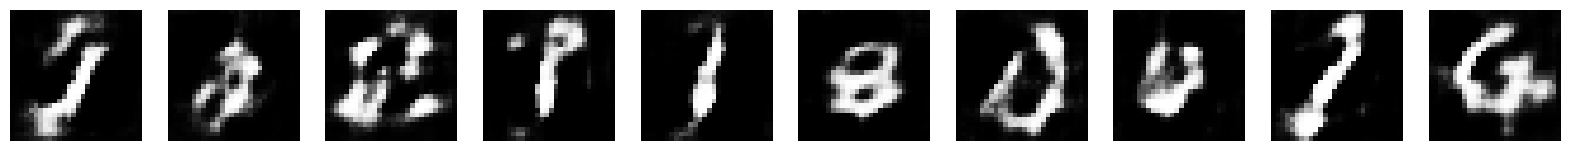

In [5]:
# Generate images after training
noise = np.random.normal(0, 1, (10, 100)) 
generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## Add more layer and residual blocks

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

np.random.seed(1000)
tf.random.set_seed(1000)

def res_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_generator():
    inputs = Input(shape=(100,))
    x = Dense(7*7*256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = res_block(x, 64)

    outputs = Conv2D(1, kernel_size=7, activation='tanh', padding='same')(x)

    model = Model(inputs, outputs)
    return model

def build_discriminator():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = res_block(x, 128)
    
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        augmented_real_images = next(datagen.flow(real_images, batch_size=half_batch, shuffle=False))

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores



In [6]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan()

32/32 [==============================] - 1s 19ms/step
0 [D loss: 0.6802120506763458, acc.: 40.625%] [G loss: 0.647905707359314] [FID: 769.5654856673951]
32/32 [==============================] - 1s 18ms/step
100 [D loss: 0.7093071937561035, acc.: 46.875%] [G loss: 0.7811297178268433] [FID: 152.69068803099935]
32/32 [==============================] - 1s 19ms/step
200 [D loss: 0.6976330876350403, acc.: 43.75%] [G loss: 0.7384997606277466] [FID: 90.55584520468979]
32/32 [==============================] - 1s 18ms/step
300 [D loss: 0.6933837532997131, acc.: 50.0%] [G loss: 0.728990912437439] [FID: 81.61930195786815]
1/1 [==============================] - 0s 79ms/step


32/32 [==============================] - 1s 19ms/step
400 [D loss: 0.6939108669757843, acc.: 53.125%] [G loss: 0.7074280977249146] [FID: 98.00262487455362]
32/32 [==============================] - 1s 20ms/step
500 [D loss: 0.7027444839477539, acc.: 46.875%] [G loss: 0.703040599822998] [FID: 95.1712517068047]
32/32 [==============================] - 1s 19ms/step
600 [D loss: 0.6576806604862213, acc.: 75.0%] [G loss: 0.7052468657493591] [FID: 92.78757570029026]
1/1 [==============================] - 0s 29ms/step


32/32 [==============================] - 1s 18ms/step
700 [D loss: 0.6887906193733215, acc.: 56.25%] [G loss: 0.7245649695396423] [FID: 101.57378926920534]
32/32 [==============================] - 1s 19ms/step
800 [D loss: 0.6817005574703217, acc.: 57.8125%] [G loss: 0.7457340955734253] [FID: 81.89596783887887]
32/32 [==============================] - 1s 19ms/step
900 [D loss: 0.7007960975170135, acc.: 45.3125%] [G loss: 0.7337229251861572] [FID: 77.6449638364826]
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step
Total training time: 222.62 seconds


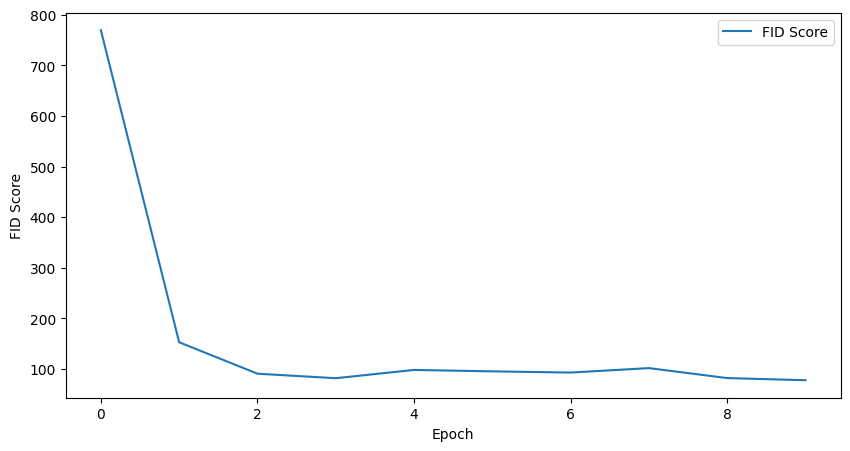

In [7]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

1/1 [==============================] - 0s 18ms/step


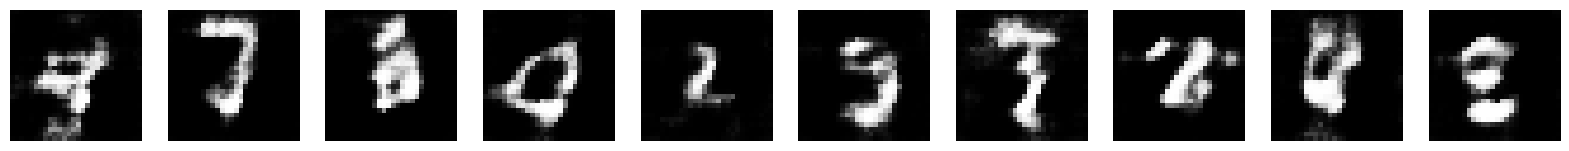

In [8]:
# Generate images after training
noise = np.random.normal(0, 1, (10, 100)) 
generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

## Add more layer

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

np.random.seed(1000)
tf.random.set_seed(1000)

def res_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_generator():
    inputs = Input(shape=(100,))
    x = Dense(7*7*256)(inputs)  # 7*7*256 instead of 512 to reduce output size
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)  # Upsample to 14x14
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)  # Upsample to 28x28
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = res_block(x, 64)
    
    outputs = Conv2D(1, kernel_size=7, activation='tanh', padding='same')(x)

    model = Model(inputs, outputs)
    return model

def build_discriminator():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 128)
    
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 256)
    
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        augmented_real_images = next(datagen.flow(real_images, batch_size=half_batch, shuffle=False))

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

In [18]:
generator, d_losses, g_losses, d_acc, fid_scores = train_gan()

32/32 [==============================] - 1s 29ms/step
0 [D loss: 2.570151627063751, acc.: 50.0%] [G loss: 0.6377719640731812] [FID: 728.83620473368]
32/32 [==============================] - 1s 29ms/step
100 [D loss: 0.0015123234770726413, acc.: 100.0%] [G loss: 0.7010592222213745] [FID: 185.8305874763081]
32/32 [==============================] - 1s 30ms/step
200 [D loss: 0.020488305017352104, acc.: 100.0%] [G loss: 1.9474384784698486] [FID: 328.368570041824]
32/32 [==============================] - 1s 30ms/step
300 [D loss: 0.017744312062859535, acc.: 100.0%] [G loss: 1.0079717636108398] [FID: 122.42883456823466]
1/1 [==============================] - 0s 152ms/step


32/32 [==============================] - 1s 29ms/step
400 [D loss: 0.00010237856440653559, acc.: 100.0%] [G loss: 0.1956372857093811] [FID: 901.9666236807996]
32/32 [==============================] - 1s 27ms/step
500 [D loss: 0.0001299371760978829, acc.: 100.0%] [G loss: 0.0677744671702385] [FID: 933.3598083848196]
32/32 [==============================] - 1s 29ms/step
600 [D loss: 0.00021354928685468622, acc.: 100.0%] [G loss: 0.05307002738118172] [FID: 941.7996816227918]
1/1 [==============================] - 0s 38ms/step


32/32 [==============================] - 1s 28ms/step
700 [D loss: 0.0001014845292957034, acc.: 100.0%] [G loss: 0.023317085579037666] [FID: 944.5953508146328]
32/32 [==============================] - 1s 30ms/step
800 [D loss: 9.629390842746943e-05, acc.: 100.0%] [G loss: 0.06153317540884018] [FID: 941.7753667495188]
32/32 [==============================] - 1s 31ms/step
900 [D loss: 6.700522499158978e-05, acc.: 100.0%] [G loss: 0.0572136715054512] [FID: 930.5118213862662]
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 34ms/step
Total training time: 369.09 seconds


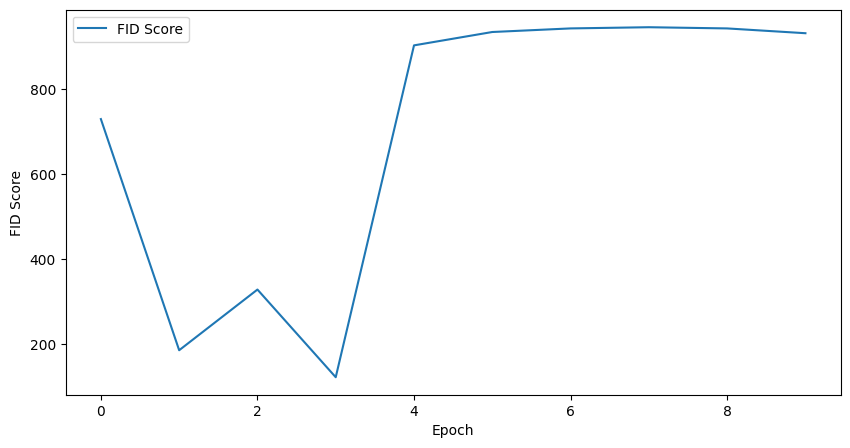

In [19]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

1/1 [==============================] - 0s 21ms/step


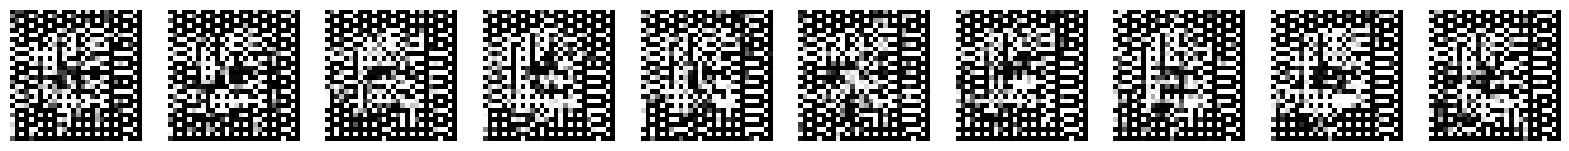

In [20]:
# Generate images after training
noise = np.random.normal(0, 1, (10, 100)) 
generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

np.random.seed(1000)
tf.random.set_seed(1000)

def res_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_generator():
    inputs = Input(shape=(100,))
    x = Dense(7*7*256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)  # 14x14x128
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)  # 28x28x64
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = res_block(x, 64)
    
    outputs = Conv2D(1, kernel_size=7, activation='tanh', padding='same')(x)  # 28x28x1

    model = Model(inputs, outputs)
    return model

def build_discriminator():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)  # 14x14x64
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)  # 7x7x128
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 128)
    
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)  # 4x4x256
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0002, 0.5))

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        augmented_real_images = next(datagen.flow(real_images, batch_size=half_batch, shuffle=False))

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    return generator, d_losses, g_losses, d_acc, fid_scores

generator, d_losses, g_losses, d_acc, fid_scores = train_gan()

32/32 [==============================] - 1s 28ms/step
0 [D loss: 0.9666518867015839, acc.: 12.5%] [G loss: 0.6585584878921509] [FID: 656.9910030829203]
32/32 [==============================] - 1s 27ms/step
100 [D loss: 0.35562118887901306, acc.: 90.625%] [G loss: 2.201460123062134] [FID: 104.7426264184851]
32/32 [==============================] - 1s 27ms/step
200 [D loss: 0.06742484960705042, acc.: 98.4375%] [G loss: 3.5533838272094727] [FID: 76.06657373337991]
32/32 [==============================] - 1s 26ms/step
300 [D loss: 0.00015172594339674106, acc.: 100.0%] [G loss: 1.1988246440887451] [FID: 1190.2587927417903]
1/1 [==============================] - 0s 46ms/step


32/32 [==============================] - 1s 27ms/step
400 [D loss: 7.281499665623414e-05, acc.: 100.0%] [G loss: 0.3858025074005127] [FID: 1247.6949965073575]
32/32 [==============================] - 1s 28ms/step
500 [D loss: 1.988258964047418e-05, acc.: 100.0%] [G loss: 0.22005575895309448] [FID: 1271.893944791617]
32/32 [==============================] - 1s 27ms/step
600 [D loss: 3.1247021979652345e-05, acc.: 100.0%] [G loss: 0.0893765389919281] [FID: 1288.6138030815525]
1/1 [==============================] - 0s 36ms/step


32/32 [==============================] - 1s 27ms/step
700 [D loss: 2.6878366952587385e-05, acc.: 100.0%] [G loss: 0.08276694267988205] [FID: 1295.494493548017]
32/32 [==============================] - 1s 27ms/step
800 [D loss: 1.843677910073893e-05, acc.: 100.0%] [G loss: 0.0937458798289299] [FID: 1297.6196889509915]
32/32 [==============================] - 1s 26ms/step
900 [D loss: 1.652105856919661e-05, acc.: 100.0%] [G loss: 0.0944514274597168] [FID: 1266.9028025264465]
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step
Total training time: 306.93 seconds


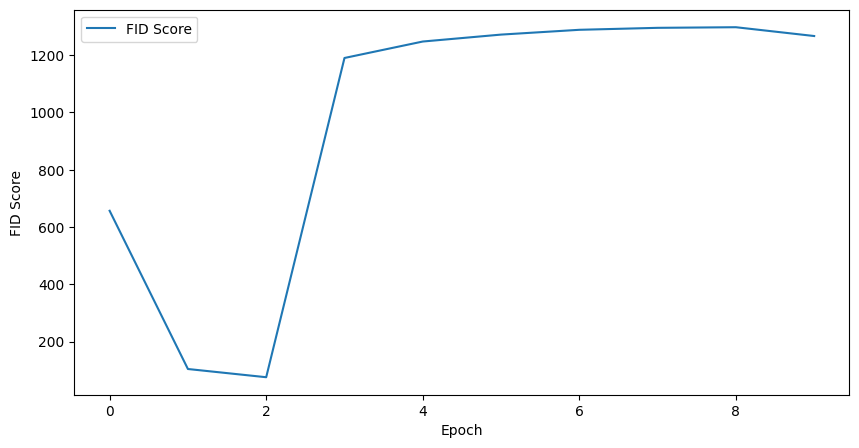

In [22]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

1/1 [==============================] - 0s 20ms/step


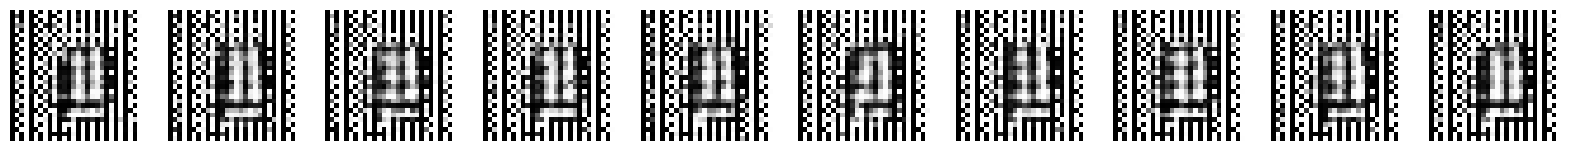

In [23]:
# Generate images after training
noise = np.random.normal(0, 1, (10, 100)) 
generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()


**为什么gan模型准确率到达100%后， fid反而变得更大了**

这是一个很常见的问题，表示判别器变得过于强大，使得生成器难以学习到好的特征。这种情况被称为判别器崩溃。以下是一些常见原因和可能的解决方法：

原因：

	1.	判别器过于强大：判别器的准确率达到100%意味着它能完美地区分真实图像和生成图像，这对生成器是不利的，因为生成器需要通过欺骗判别器来提高自身的性能。
	2.	生成器训练不足：生成器可能没有足够的机会进行训练，导致它生成的图像质量没有改善。
	3.	损失函数的问题：标准的交叉熵损失可能会导致不稳定的训练，尤其是在判别器非常强大的情况下。

解决方法：

	1.	平衡生成器和判别器的训练：
	•	可以在每次训练生成器时训练判别器多次，反之亦然。
	•	限制判别器的能力，例如通过减少判别器的层数或神经元数量。
	2.	使用改进的GAN架构：
	•	Wasserstein GAN (WGAN)：使用Earth-Mover’s距离作为损失函数，改善训练的稳定性。
	•	WGAN-GP (Gradient Penalty)：在WGAN的基础上添加梯度惩罚，进一步提高训练稳定性。
	•	LSGAN (Least Squares GAN)：使用最小二乘损失，替代交叉熵损失，能够缓解训练不稳定的问题。
	3.	标签平滑（Label Smoothing）：对真实标签和假标签进行轻微的扰动，防止判别器过于自信。
	4.	对抗性训练技巧：
	•	随机噪声：在训练判别器时对其输入添加少量噪声，防止其过拟合。
	•	提前停止判别器的训练：在判别器的准确率达到一定值后停止其训练，给生成器更多的机会进行学习。

以下是改进后的代码，使用Wasserstein GAN（WGAN）并添加梯度惩罚（WGAN-GP）：

32/32 [==============================] - 1s 31ms/step
0 [D loss: 1.33087158203125, acc.: 20.3125%] [G loss: 0.7551804780960083] [FID: 680.8877201481116]
32/32 [==============================] - 1s 28ms/step
100 [D loss: 0.2625742554664612, acc.: 92.1875%] [G loss: 1.7392644882202148] [FID: 99.71096613229861]
32/32 [==============================] - 1s 27ms/step
200 [D loss: 0.05241437070071697, acc.: 96.875%] [G loss: 1.7570847272872925] [FID: 120.28258980227442]
32/32 [==============================] - 1s 30ms/step
300 [D loss: 0.0029334434075281024, acc.: 100.0%] [G loss: 0.8263434767723083] [FID: 506.90846718960495]
1/1 [==============================] - 0s 154ms/step


32/32 [==============================] - 1s 28ms/step
400 [D loss: 0.0008248392259702086, acc.: 100.0%] [G loss: 0.4867098927497864] [FID: 724.456821239973]
32/32 [==============================] - 1s 29ms/step
500 [D loss: 0.00020002200471935794, acc.: 100.0%] [G loss: 0.3112916350364685] [FID: 869.622812345485]
32/32 [==============================] - 1s 27ms/step
600 [D loss: 8.487402556056622e-05, acc.: 100.0%] [G loss: 0.26330870389938354] [FID: 1000.1455275678254]
1/1 [==============================] - 0s 34ms/step


32/32 [==============================] - 1s 29ms/step
700 [D loss: 3.479689530649921e-05, acc.: 100.0%] [G loss: 0.11444135755300522] [FID: 1094.4309051914183]
32/32 [==============================] - 1s 30ms/step
800 [D loss: 3.804103153015603e-05, acc.: 100.0%] [G loss: 0.14428354799747467] [FID: 1159.6181634820923]
32/32 [==============================] - 1s 30ms/step
900 [D loss: 2.20510864892276e-05, acc.: 100.0%] [G loss: 0.13127794861793518] [FID: 1213.6255099792859]
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 37ms/step
Total training time: 366.62 seconds


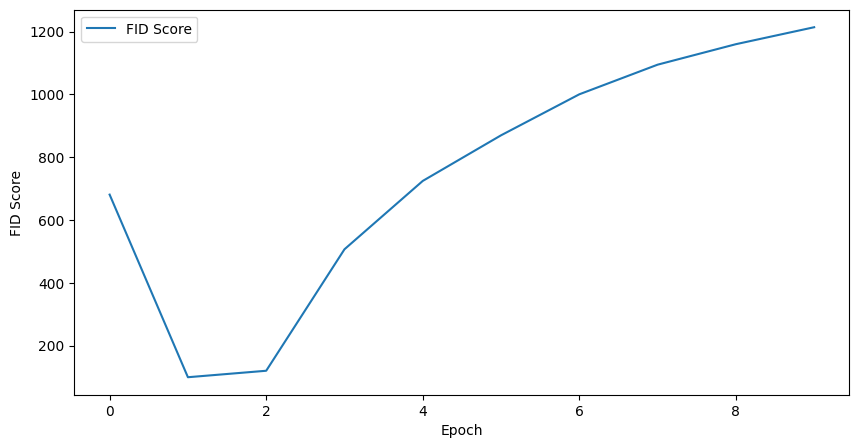

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

np.random.seed(1000)
tf.random.set_seed(1000)

def res_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_generator():
    inputs = Input(shape=(100,))
    x = Dense(7*7*256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)  # 14x14x128
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)  # 28x28x64
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = res_block(x, 64)
    
    outputs = Conv2D(1, kernel_size=7, activation='tanh', padding='same')(x)  # 28x28x1

    model = Model(inputs, outputs)
    return model

def build_discriminator():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)  # 14x14x64
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)  # 7x7x128
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 128)
    
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)  # 4x4x256
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 256)
    
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0001, 0.5), metrics=['accuracy'])  # Adjusted learning rate
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0001, 0.5))  # Adjusted learning rate

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        augmented_real_images = next(datagen.flow(real_images, batch_size=half_batch, shuffle=False))

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}]")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label="FID Score")
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")
    plt.legend()
    plt.show()

    return generator, d_losses, g_losses, d_acc, fid_scores

generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)  # Reduced epochs for testing

## One side label smoothing - 0.9

32/32 [==============================] - 1s 28ms/step
0 [D loss: 1.316241204738617, acc.: 7.8125%] [G loss: 0.7253826856613159] [FID: 702.7046984689903] [Time: 2.90s]
32/32 [==============================] - 1s 30ms/step
100 [D loss: 0.4186857268214226, acc.: 46.875%] [G loss: 1.9962726831436157] [FID: 109.53543988815284] [Time: 41.13s]
32/32 [==============================] - 1s 28ms/step
200 [D loss: 0.22391166165471077, acc.: 50.0%] [G loss: 1.8297282457351685] [FID: 177.4303434008085] [Time: 77.83s]
32/32 [==============================] - 1s 27ms/step
300 [D loss: 0.17859381018206477, acc.: 50.0%] [G loss: 1.829963207244873] [FID: 238.55410047538223] [Time: 114.55s]
1/1 [==============================] - 0s 64ms/step


32/32 [==============================] - 1s 29ms/step
400 [D loss: 0.20929156616330147, acc.: 50.0%] [G loss: 1.4563958644866943] [FID: 107.06278378008005] [Time: 151.12s]
32/32 [==============================] - 1s 28ms/step
500 [D loss: 0.16961277113296092, acc.: 50.0%] [G loss: 2.4595465660095215] [FID: 233.8029804782993] [Time: 188.05s]
32/32 [==============================] - 1s 29ms/step
600 [D loss: 0.1690616102423519, acc.: 50.0%] [G loss: 2.010890007019043] [FID: 153.30321894326144] [Time: 224.78s]
1/1 [==============================] - 0s 35ms/step


32/32 [==============================] - 1s 29ms/step
700 [D loss: 0.18174016941338778, acc.: 50.0%] [G loss: 1.8667889833450317] [FID: 88.50863832749641] [Time: 261.51s]
32/32 [==============================] - 1s 28ms/step
800 [D loss: 0.20721716166008264, acc.: 50.0%] [G loss: 1.3546152114868164] [FID: 77.41204010477632] [Time: 298.37s]
32/32 [==============================] - 1s 26ms/step
900 [D loss: 0.16713810211513191, acc.: 50.0%] [G loss: 1.962188482284546] [FID: 81.91354850150165] [Time: 334.71s]
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step
Total training time: 368.20 seconds


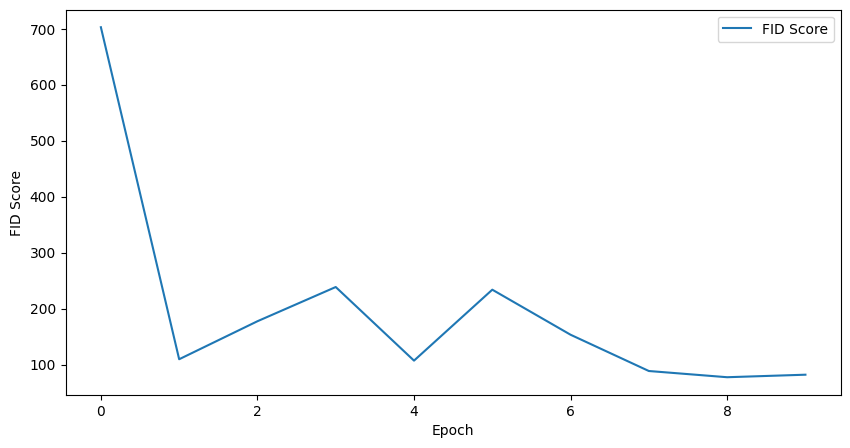

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

np.random.seed(1000)
tf.random.set_seed(1000)

def res_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_generator():
    inputs = Input(shape=(100,))
    x = Dense(7*7*256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)  # 14x14x128
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)  # 28x28x64
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = res_block(x, 64)
    
    outputs = Conv2D(1, kernel_size=7, activation='tanh', padding='same')(x)  # 28x28x1

    model = Model(inputs, outputs)
    return model

def build_discriminator():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)  # 14x14x64
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)  # 7x7x128
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 128)
    
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)  # 4x4x256
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 256)
    
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0001, 0.5), metrics=['accuracy'])  # Adjusted learning rate
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0001, 0.5))  # Adjusted learning rate

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()

    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        augmented_real_images = next(datagen.flow(real_images, batch_size=half_batch, shuffle=False))

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1)) * 0.9  # One-sided label smoothing for real images
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}] [Time: {time.time() - start_time:.2f}s]")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label="FID Score")
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")
    plt.legend()
    plt.show()

    return generator, d_losses, g_losses, d_acc, fid_scores

generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)  # Reduced epochs for testing

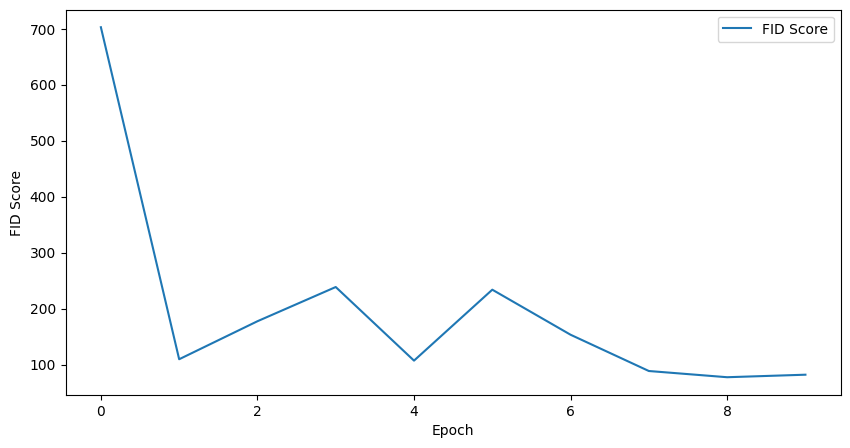

1/1 [==============================] - 0s 21ms/step


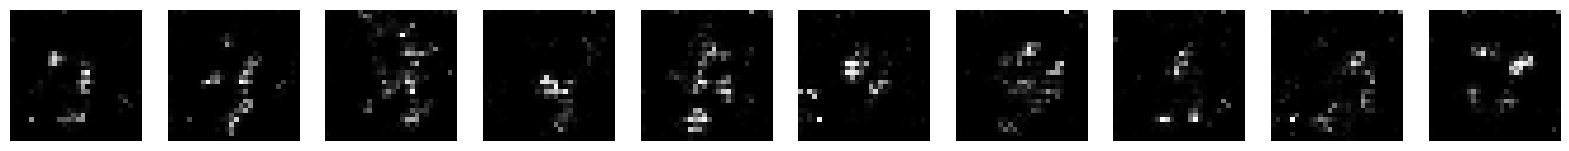

In [32]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# Generate images after training
noise = np.random.normal(0, 1, (10, 100)) 
generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()

32/32 [==============================] - 1s 29ms/step
0 [D loss: 1.4799704551696777, acc.: 1.5625%] [G loss: 0.7208865880966187] [FID: 733.5123998408278] [Epoch Time: 1.02s]
32/32 [==============================] - 1s 28ms/step
100 [D loss: 0.6024261862039566, acc.: 31.25%] [G loss: 1.6779794692993164] [FID: 109.02885768097852] [Epoch Time: 0.34s]
32/32 [==============================] - 1s 30ms/step
200 [D loss: 0.3162115812301636, acc.: 48.4375%] [G loss: 2.0835633277893066] [FID: 71.39573988374792] [Epoch Time: 0.35s]
32/32 [==============================] - 1s 30ms/step
300 [D loss: 0.11431072582490742, acc.: 50.0%] [G loss: 1.6525179147720337] [FID: 184.60356895005475] [Epoch Time: 0.36s]


32/32 [==============================] - 1s 26ms/step
400 [D loss: 0.10484713048208505, acc.: 50.0%] [G loss: 0.9144115447998047] [FID: 554.9105792278531] [Epoch Time: 0.35s]
32/32 [==============================] - 1s 27ms/step
500 [D loss: 0.10644233695347793, acc.: 50.0%] [G loss: 1.3033955097198486] [FID: 661.6581832273639] [Epoch Time: 0.34s]
32/32 [==============================] - 1s 31ms/step
600 [D loss: 0.11164388072211295, acc.: 50.0%] [G loss: 1.1360459327697754] [FID: 633.4862077645435] [Epoch Time: 0.36s]
1/1 [==============================] - 0s 35ms/step


32/32 [==============================] - 1s 28ms/step
700 [D loss: 0.10520486161112785, acc.: 50.0%] [G loss: 1.4733127355575562] [FID: 512.3280205202336] [Epoch Time: 0.35s]
32/32 [==============================] - 1s 27ms/step
800 [D loss: 0.11192459485027939, acc.: 50.0%] [G loss: 1.4415526390075684] [FID: 508.24854576479254] [Epoch Time: 0.34s]
32/32 [==============================] - 1s 29ms/step
900 [D loss: 0.10520046192687005, acc.: 50.0%] [G loss: 1.326124668121338] [FID: 394.4011959126324] [Epoch Time: 0.35s]
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step
Total training time: 371.00 seconds


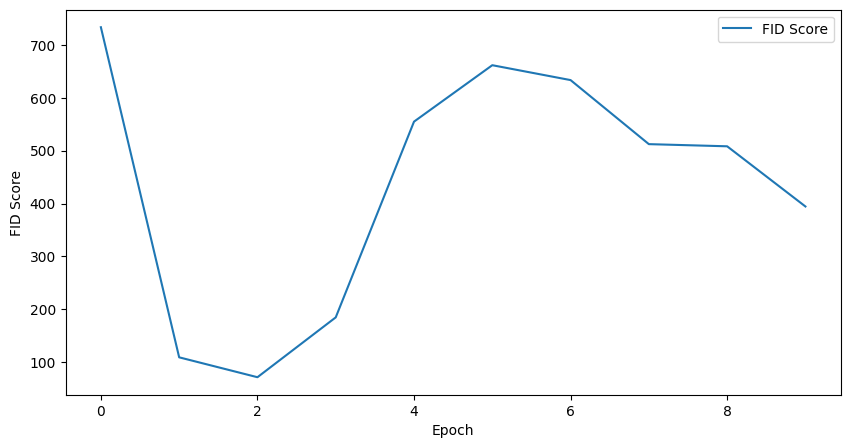

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, BatchNormalization, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

np.random.seed(1000)
tf.random.set_seed(1000)

def res_block(x, filters, kernel_size=3, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Add()([x, shortcut])
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_generator():
    inputs = Input(shape=(100,))
    x = Dense(7*7*256)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((7, 7, 256))(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)  # 14x14x128
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)  # 28x28x64
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = res_block(x, 64)
    
    outputs = Conv2D(1, kernel_size=7, activation='tanh', padding='same')(x)  # 28x28x1

    model = Model(inputs, outputs)
    return model

def build_discriminator():
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)  # 14x14x64
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)  # 7x7x128
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 128)
    
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)  # 4x4x256
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    x = res_block(x, 256)
    
    x = Flatten()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

def calculate_fid(real_images, fake_images):
    act1 = real_images.reshape((real_images.shape[0], -1))
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    
    act2 = fake_images.reshape((fake_images.shape[0], -1))
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

def train_gan(epochs=1000, batch_size=64, p_epoch=100):
    generator = build_generator()
    discriminator = build_discriminator()

    discriminator.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0001, 0.5), metrics=['accuracy'])  # Adjusted learning rate
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=legacy_optimizers.Adam(0.0001, 0.5))  # Adjusted learning rate

    half_batch = int(batch_size / 2)
    
    d_losses = []
    g_losses = []
    d_acc = []
    fid_scores = []
    
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()  # Record epoch start time
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        real_images = x_train[idx]

        augmented_real_images = next(datagen.flow(real_images, batch_size=half_batch, shuffle=False))

        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)

        real_labels = np.ones((half_batch, 1)) * 0.95  # One-sided label smoothing for real images
        fake_labels = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(augmented_real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_y)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        d_acc.append(d_loss[1] * 100)
        
        epoch_end_time = time.time()  # Record epoch end time

        if epoch % p_epoch == 0:
            noise = np.random.normal(0, 1, (1000, 100))
            fake_images = generator.predict(noise)
            fid = calculate_fid(x_train[:1000], fake_images)
            fid_scores.append(fid)
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}] [FID: {fid}] [Epoch Time: {epoch_end_time - epoch_start_time:.2f}s]")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")
    
    plt.figure(figsize=(10, 5))
    plt.plot(fid_scores, label="FID Score")
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")
    plt.legend()
    plt.show()

    return generator, d_losses, g_losses, d_acc, fid_scores

generator, d_losses, g_losses, d_acc, fid_scores = train_gan(epochs=1000)  # Adjusted epochs for full training

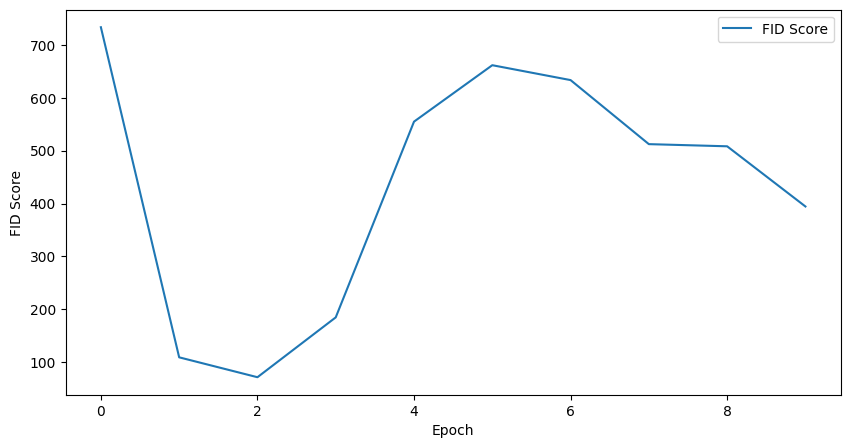

1/1 [==============================] - 0s 20ms/step


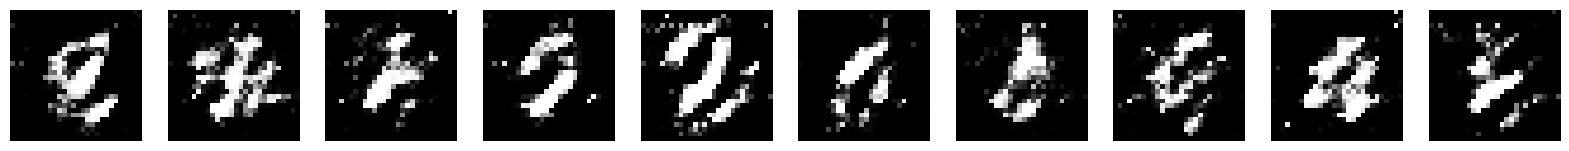

In [34]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.show()

# Generate images after training
noise = np.random.normal(0, 1, (10, 100)) 
generated_images = generator.predict(noise)

# Denormalization process, converting data in the range of [-1, 1] to the range of [0, 1]
generated_images = 0.5 * generated_images + 0.5

fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
    axs[i].axis('off')
plt.show()